# Онлайн алгоритмы в задаче формирования портфеля ценных бумаг

## Постановка задачи

В задаче формирования портфеля ценных бумаг допустимыми решениями являются всевозможные распределения состояния, имеющегося у игрока, т.е. элементы стандартного симплекса:

$$
\Delta_d = \left\{
x \in \mathbb{R}^d
:\;
\sum_{i = 1}^d x_i = 1,
\;
x_i \geq 0
\right\}.
$$

Противник (природа) независимо выбирает рыночную доходность активов,
т.е. вектор $r_t \in \mathbb{R}_+^d$,
у которого $i$-ая компонента определяется формулой

$$
[r_t]_i = \frac{\text{цена единицы $i$-го актива в момент } t + 1}{\text{цена единицы $i$-го актива в момент } t}.
$$

*Цель игрока* — максимизировать свое состояние по проишествии $T$ раундов, которая эквивалентна максимизации величины

$$
\sum_{t=1}^T \log r_t^\top x_t,
$$

которую будем называть *логарифмическим приростом* портфеля ценных бумаг к моменту времени $T$.

Регрет алгоритма $\mathcal{A}$ к раунду $T$ определяется формулой

$$
\mathrm{regret}_T(\mathcal{A})
=
\sum_{t=1}^T f_t(x_t)
-
\min_{x \in \Delta_d}
\sum_{t = 1}^T f_t(x),
$$

где $f_t(x) = -\log r_t^\top x$.

В этом задании вам предстоит реализовать алгоритмического инвестора на основе онлайн градиентного спуска, принимающего решения о перераспределении имеющихся средств между акциями российского фондового рынка:
- в момент времени $t$ алгоритм должен предложить распределение средств между активами $x_t$;
- после этого алгоритму открывается вектор рыночных доходностей $r_t$ из истории наблюдений;
- алгоритм должен использовать поступившую информацию для корректировки и принятия решения на следующей итерации.

## Подготовка данных (3 балла)

Загрузите котировки (сформируйте набор данных) акций `RASP`, `GAZP`, `DSKY`, `SBER`, `KMAZ`, `RUAL` c 01.04.2020 по 22.04.2022 с интервалом в один день (раунд игры = день). Выведите таблицу (`pd.DataFrame`), в которой столбцы содержат временные ряды для каждого тикера, а их названия — тикеры. **[1 балл]**

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from numpy.typing import ArrayLike

In [4]:
# загрузка и подготовка данных
tickers = ['RASP.ME', 'GAZP.ME', 'DSKY.ME', 'SBER.ME', 'KMAZ.ME', 'RUAL.ME']
data = pd.DataFrame(columns=tickers)
data = yf.download(tickers,'2020-04-01','2022-04-22')['Adj Close']

display(data)

[*********************100%***********************]  6 of 6 completed


,DSKY.ME,GAZP.ME,KMAZ.ME,RASP.ME,RUAL.ME,SBER.ME
Date,,,,,,
2020-04-01,76.164970,158.852737,50.642338,80.271103,24.754999,131.187042
2020-04-02,76.587524,165.010651,50.245144,81.617722,24.955000,132.727646
2020-04-03,79.799110,167.419113,53.224102,81.371384,24.830000,131.797607
2020-04-06,82.655716,168.592468,54.018497,82.865791,25.754999,135.390030
2020-04-07,82.926163,168.698334,54.217091,81.272858,26.049999,140.310089
...,...,...,...,...,...,...
2022-04-15,77.720001,224.000000,100.099998,398.600006,66.750000,130.880005
2022-04-18,75.599998,216.990005,100.099998,403.149994,64.605003,123.849998
2022-04-19,75.199997,220.720001,99.300003,391.149994,63.200001,120.300003


Визуализируйте поведение всех тикеров на всём горизонте игры. **[1 балл]**

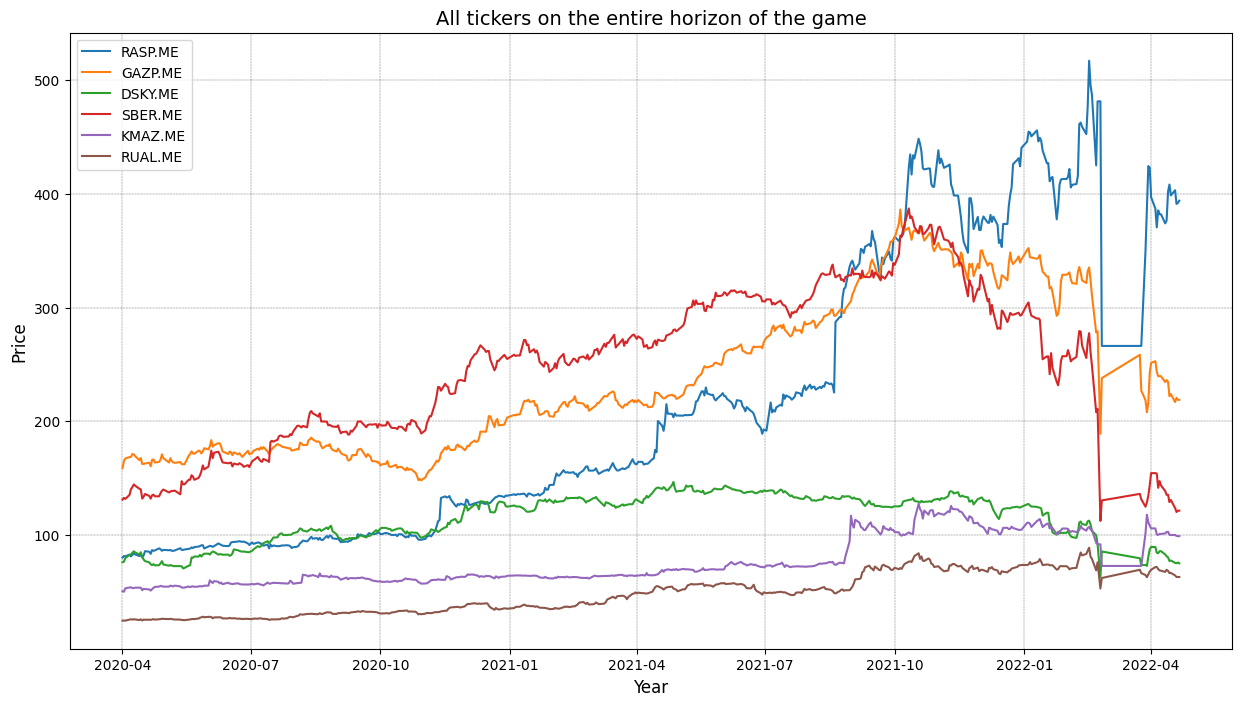

In [5]:
# красивая визуализация на графике с подписями и адекватным масштабом
plt.figure(figsize=(15,8))
for ticker in tickers:
    plt.plot(data.index, data[ticker], label=ticker)

plt.legend(loc='upper left')

plt.title("All tickers on the entire horizon of the game", fontsize=14)

plt.ylabel('Price', fontsize=12)
plt.xlabel('Year', fontsize=12)

plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
plt.show()

Постройте таблицу (с тем же заголовком), содержащую по столбцам временные ряды *рыночных доходностей* тикеров. **[1 балл]**


In [6]:
# расчет рыночных доходностей
returns = data.pct_change().dropna()

returns.columns = [col for col in returns.columns]

print("All tickers on the entire horizon of the game")
display(returns.abs())

All tickers on the entire horizon of the game


,DSKY.ME,GAZP.ME,KMAZ.ME,RASP.ME,RUAL.ME,SBER.ME
Date,,,,,,
2020-04-02,0.005548,0.038765,0.007843,0.016776,0.008079,0.011744
2020-04-03,0.041934,0.014596,0.059288,0.003018,0.005009,0.007007
2020-04-06,0.035797,0.007008,0.014925,0.018365,0.037253,0.027257
2020-04-07,0.003272,0.000628,0.003676,0.019223,0.011454,0.036340
2020-04-08,0.019160,0.015113,0.016483,0.017175,0.011516,0.013459
...,...,...,...,...,...,...
2022-04-15,0.006214,0.008509,0.001994,0.023398,0.001500,0.014181
2022-04-18,0.027277,0.031295,0.000000,0.011415,0.032135,0.053713
2022-04-19,0.005291,0.017190,0.007992,0.029766,0.021748,0.028664


## Онлайн градиентный спуск (8 баллов)

Приведите выражение для градиента функции $f_t(x)$ и запишите явную формулу для итерации OGD. **[1 балл]**

*Место для выкладок.*

Реализуйте инвестора, принимающего решение на основе итераций онлайн градиентного спуска. **[4 балла]**

Используйте готовую функцию `simplex_projection`, проектирующую входной вектор на стандартный симплекс.

In [7]:
def _unsafe_simplex_projection(s: ArrayLike, norm_constraint: float) -> ArrayLike:
    """Находит проекцию на симплекс."""
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(u) + 1) > (cssv - norm_constraint))[0][-1]
    theta = (cssv[rho] - norm_constraint) / (rho + 1.0)
    return np.maximum(s - theta, 0)


def simplex_projection(s: ArrayLike):
    """Возвращает проекцию на единичный симплекс."""
    return s if np.sum(s) == 1 else _unsafe_simplex_projection(s, 1.0)

In [8]:
# реализация онлайн градиентного спуска

### Запуск OGD

Как будете выбирать шаг при запуске OGD? Приведите исчерпывающее объяснение и мотивацию. **[1 балл]**

*Место для выкладок.*

Начиная с равномерного распределения состояния между активами, запустите OGD на всём горизонте игры. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, зафиксировавшего своё (произвольное) распределение в начале игры. **[2 балла]**

In [9]:
# красивая визуализация на графике с подписями и адекватным масштабом

## Дополнительное задание (4 балла)

Реализуйте любой подходящий канонический онлайн алгоритм из курса или даже их композицию. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, принимающего решения на основе выбранного алгоритма. Сравните итоговые распределения, полученные с помощью этих алгоритмов, и попробуйте сделать выводы.

In [10]:
# место для кода